In [28]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import csv

from sklearn.feature_extraction.text import TfidfVectorizer 

#### Load Recipes Data

In [29]:
recipes = json.load(open('./data/recipe_train.json'))

#### Convert recipe to text document

In [30]:
recipes_as_doc = {}

for sample in recipes:
    key = sample['cuisine']
    # If key is in the dictionary, return its value. If not, insert key with a value of default and return default.
    recipes_as_doc.setdefault(key,[]).append(' '.join(sample['ingredients']).lower())

# create a single list with all the documents
all_docs = []
for k, v in recipes_as_doc.items():
   all_docs.append(' '.join(v))

#### Tfidf vectorizer for text data

In [31]:
# code adapted from https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf

vectorizer = TfidfVectorizer(use_idf=True)
transformed_documents = vectorizer.fit_transform(all_docs)

#### Analyze results

In [32]:
transformed_documents_as_array = transformed_documents.toarray()
len(transformed_documents_as_array)
docsTermsScoresDfs = {}

# loop each item in transformed_documents_as_array, using enumerate to keep track of the current position
for counter, doc in enumerate(transformed_documents_as_array):
    # construct a dataframe
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame\
        .from_records(tf_idf_tuples, columns=['term', 'score'])\
        .sort_values(by='score', ascending=False)\
        .reset_index(drop=True)
    docsTermsScoresDfs[list(recipes_as_doc.keys())[counter]] = one_doc_as_df

    print(list(recipes_as_doc.keys())[counter], end=' ')
    # print(one_doc_as_df)
    # output to a csv using the enumerated value for the filename
    #one_doc_as_df.to_csv("tf.idf" + counter.__str__() + ".csv")

greek southern_us filipino indian jamaican spanish italian mexican chinese british thai vietnamese cajun_creole brazilian french japanese irish korean moroccan russian 

#### Statistics of Scores

Text(0, 0.5, 'Number of Therms')

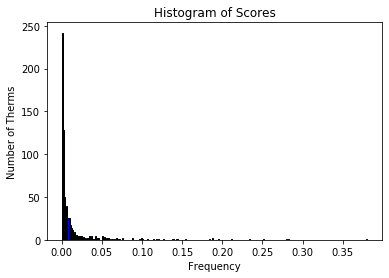

In [33]:
statistics = {}
for k in docsTermsScoresDfs.keys():
    df = docsTermsScoresDfs[k]
    scores = df['score']
    scores = scores.loc[scores>0.0]
    s = [scores.mean(), scores.max(), scores.min(), df['score'].astype(bool).sum(axis=0)]
    statistics[k] = pd.DataFrame(s, index=['mean','max','min','non_zeros'])

scores = docsTermsScoresDfs["irish"]["score"]
scores = scores.loc[scores>0.0]
plt.hist(scores, color = 'blue', edgecolor = 'black', bins=300)
plt.title('Histogram of Scores')
plt.xlabel('Frequency')
plt.ylabel('Number of Therms')
# print(statistics)

#### Load Baskets Market Data

In [34]:
baskets = []
with open('./data/groceries.csv', newline=None) as f:
  reader = csv.reader(f)
  for row in reader:
    baskets.append(row)